In [1]:
from jaxl.constants import *
from jaxl.datasets import get_dataset
from jaxl.learning_utils import get_learner
from jaxl.utils import parse_dict

import json
import numpy as np
import os

from orbax.checkpoint import PyTreeCheckpointer, CheckpointManager

In [2]:
base_dir = "/Users/chanb/research/personal/jaxl/jaxl"
# learner_path = os.path.join(
#     base_dir,
#     "logs/icl-linear_sgd-full_context_20/gpt-no_enc-08-21-23_07_36_59-971a17db-73ed-4f77-b463-5887644e3385"
# )
learner_path = os.path.join(
    base_dir,
    "logs/icl-linear_sgd-full_context_20/gpt-pos_enc-08-21-23_07_36_58-5473978c-10db-433b-889b-f136405d7a7e",
)
# learner_path = "/Users/chanb/research/personal/jaxl/jaxl/logs/icl-linear_sgd-full_context_20/gpt-low_embed-08-23-23_07_20_59-0876bed6-f8b6-47f6-ab3a-7bba4b2b4308"
test_dataset_seed = 999

In [3]:
config_path = os.path.join(learner_path, "config.json")
with open(config_path, "r") as f:
    config_dict = json.load(f)
    config = parse_dict(config_dict)

learner = get_learner(
    config.learner_config, config.model_config, config.optimizer_config
)

checkpoint_manager = CheckpointManager(
    os.path.join(learner_path, "models"),
    PyTreeCheckpointer(),
)

params = checkpoint_manager.restore(checkpoint_manager.latest_step())
params[CONST_MODEL_DICT][CONST_MODEL][CONST_POSITIONAL_ENCODING] = dict()
model = learner._model

In [4]:
config.learner_config.dataset_config

namespace(dataset_name='multitask_toy_regression',
          dataset_kwargs=namespace(basis='polynomial',
                                   degree=1,
                                   num_sequences=100000,
                                   sequence_length=41,
                                   noise=0.1,
                                   params_bound=[-10.0, 10.0],
                                   val_frac=0.0005),
          dataset_wrapper=namespace(type='ContextDataset',
                                    kwargs=namespace(context_len=20,
                                                     skip_step=1)))

In [5]:
sequence_len = 80
test_config = vars(config.learner_config.dataset_config)
test_config["dataset_kwargs"] = vars(test_config["dataset_kwargs"])
test_config["dataset_kwargs"]["sequence_length"] = sequence_len + 1
test_config["dataset_kwargs"]["params_bound"] = [-0.5, 0.5]
test_config["dataset_kwargs"]["inputs_range"] = [-1.0, 1.0]
test_config = parse_dict(test_config)

In [6]:
test_dataset = get_dataset(test_config, seed=test_dataset_seed)

In [7]:
def get_result(dataset, sequence_length):
    context_inputs, context_outputs, queries, outputs = [], [], [], []
    for seq_i in range(sequence_length):
        context_input, context_output, query, output = dataset[seq_i]
        context_inputs.append(context_input)
        context_outputs.append(context_output)
        queries.append(query)
        outputs.append(output)
    context_inputs = np.stack(context_inputs)
    context_outputs = np.stack(context_outputs)
    queries = np.stack(queries)
    outputs = np.stack(outputs)

    preds, _ = model.forward(
        params[CONST_MODEL_DICT][CONST_MODEL],
        queries,
        {
            CONST_CONTEXT_INPUT: context_inputs,
            CONST_CONTEXT_OUTPUT: context_outputs,
        },
    )
    return queries, preds, outputs, context_inputs, context_outputs

In [8]:
def mse(preds, outputs):
    return np.mean((preds - outputs) ** 2)

In [9]:
queries, preds, outputs, context_inputs, context_outputs = get_result(
    test_dataset, sequence_length=sequence_len
)
loss = mse(preds, outputs)
print(queries.shape, preds.shape, outputs.shape)

(80, 1, 1) (80, 1) (80, 1)


In [10]:
loss

Array(0.06893671, dtype=float32)

# Basic Prediction Result

In [11]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'output')

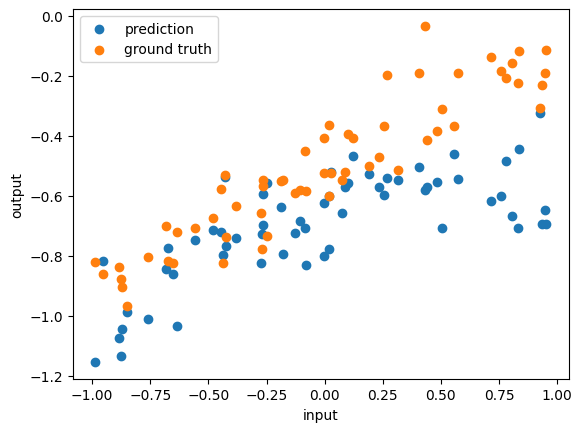

In [12]:
context_len = config.learner_config.dataset_config.dataset_wrapper.kwargs.context_len
plt.scatter(queries[context_len:], preds[context_len:], label="prediction")
plt.scatter(queries[context_len:], outputs[context_len:], label="ground truth")
plt.legend()
plt.xlabel("input")
plt.ylabel("output")

In [13]:
def get_latent(dataset, sequence_length):
    context_inputs, context_outputs, queries, outputs = [], [], [], []
    for seq_i in range(sequence_length):
        context_input, context_output, query, output = dataset[seq_i]
        context_inputs.append(context_input)
        context_outputs.append(context_output)
        queries.append(query)
        outputs.append(output)
    context_inputs = np.stack(context_inputs)
    context_outputs = np.stack(context_outputs)
    queries = np.stack(queries)
    outputs = np.stack(outputs)

    latent, _ = model.get_latent(
        params[CONST_MODEL_DICT][CONST_MODEL],
        queries,
        {
            CONST_CONTEXT_INPUT: context_inputs,
            CONST_CONTEXT_OUTPUT: context_outputs,
        },
    )
    return queries, latent[:, -1]

In [14]:
queries, latents = get_latent(test_dataset, sequence_length=sequence_len)
print(queries.shape, latents.shape)

(80, 1, 1) (80, 64)


In [15]:
from jaxl.utils import l2_norm

In [16]:
print(np.sum(latents, axis=0))
print(np.sum(latents, axis=1))
print(latents)

[-8.70445251e+01 -4.92759466e+00 -1.86562119e+01 -5.30103259e-02
  1.38190918e+01  3.70041966e-01 -1.41877575e+01 -6.86497345e+01
 -9.60862255e+00  3.27395976e-01 -2.21627206e-01  4.60476723e+01
  3.24487686e-04 -8.30300293e+01 -6.01868858e+01 -2.06613045e+01
  5.92973852e+00  1.43881168e+01  3.13285789e+01 -2.86045685e+01
  5.33899355e+00 -4.43501631e-03 -1.74550724e+01  6.39002398e-02
 -6.70036972e-02 -1.10124121e+01 -6.41341114e+00 -4.70775070e+01
  3.10451753e-04  2.57284279e+01 -6.34907532e+01 -2.36261985e-04
  5.30854034e+01  3.52241492e+00 -6.84609473e-01 -4.80400229e+00
  1.05822548e-01  3.65287552e+01  1.54533577e+01  2.20875168e+01
 -1.36101227e+01  1.73424572e-01  1.12566829e+00 -4.38309908e-02
  1.78348083e+01 -3.60394168e+00  6.67270126e+01 -5.07296791e+01
 -2.37078934e+01 -3.20220669e-03 -2.96034317e+01  2.16853180e+01
  3.46095390e+01 -6.05618019e+01 -9.58636589e-03  1.83653030e+01
 -1.16213818e+01  4.52449684e+01 -1.96898003e+01  3.48247923e-02
  3.45666351e+01 -1.54455

In [23]:
len(
    np.where(
        np.abs(params["model_dict"]["model"]["predictor"]["params"]["kernel"]) < 1e-3
    )[0]
)

13

In [24]:
params["model_dict"]["model"]["predictor"]["params"]["kernel"].shape

(64, 1)

In [25]:
model.embed_dim

64

In [26]:
context_len

20